# Plot massive 

In [281]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re

In [213]:
today = datetime.date.today()
print(today)

2020-08-04


In [214]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v4.pdf'.format(today)

In [215]:
# enhancer-gene linkage
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)
enhancer_gene_to_eval.head()

(2589994, 18)


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [216]:
# # 

# ka_list = [2, 5, 10, 20, 50, 100, 200] 
# k_list = [2, 50, 10, 20, 50, 100, 200]

# num_bins = 200
# bins = np.linspace(-1, 0.3, num_bins)
# fdr_threshold = 0.2
# label = 'pairs (<100kb)'


# res = []

# for ka in ka_list:
#     for k in k_list:
#         # 
#         output_corr = output_corr_format.format(ka, k)
#         output_to_correlate = output_to_correlate_format.format(ka, k)
        
#         # try loading the list
#         try:
#             with open(output_corr, 'rb') as fh:
#                 corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
#             print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

#             with open(output_to_correlate, 'rb') as fh:
#                 to_correlate = pickle.load(fh)
#             print(to_correlate.shape)
#         except:
#             continue
        
#         # dists 
#         dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
        
# #         ## total numbers
# #         num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
# #         num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
# #         num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
        
        
#         ## sig numbers
#         label_cond = dists < 1e5
#         track = corrs[label_cond]
        
#         ### total numbers with the condition
#         num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
#         num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
#         num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

#         hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
#         cdf_shuff = np.cumsum(hist_shuff)
#         # dist
#         hist, _ = np.histogram(track, bins=bins, normed=True)
#         cdf = np.cumsum(hist)
#         # fdr
#         fdr = cdf_shuff/cdf

#         # get r_threshold
#         # remove nan
#         isnan = np.isnan(fdr)
#         _y = fdr[~isnan]
#         _x = bins[1:][~isnan]
#         # find r threshold
#         try:
#             f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
#             r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
#         except:
#             r_threshold = 0

#         sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

#         # num_sig
#         num_sig_pairs = len(sig_table)
#         num_sig_genes = len(sig_table['gene'].unique()) 
#         num_sig_enhs = len(sig_table['ens'].unique()) 

#         # record
#         res.append({
#             'ka': ka,
#             'k': k,
#             'num_total_pairs': num_total_pairs,
#             'num_total_genes': num_total_genes,
#             'num_total_enhs': num_total_enhs,
#             'num_sig_pairs': num_sig_pairs,
#             'num_sig_genes': num_sig_genes,
#             'num_sig_enhs': num_sig_enhs,
#             'r_threshold': r_threshold,
#         })
        
# res = pd.DataFrame(res)[[
#             'ka',
#             'k',
#             'num_sig_pairs',
#             'num_sig_genes',
#             'num_sig_enhs',
#             'r_threshold',
#             'num_total_pairs',
#             'num_total_genes',
#             'num_total_enhs',
# ]] 
# print(res.shape)
# res.head()

(1546436,) (1546436,) (1546436,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


(1539635,) (1539635,) (1539635,)
(2589994,)
(1543164,) (1543164,) (1543164,)
(2589994,)
(1546273,) (1546273,) (1546273,)
(2589994,)
(1539635,) (1539635,) (1539635,)
(2589994,)
(1539798,) (1539798,) (1539798,)
(2589994,)
(1522985,) (1522985,) (1522985,)
(2589994,)
(1532335,) (1532335,) (1532335,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1555150,) (1555150,) (1555150,)
(2589994,)
(1538700,) (1538700,) (1538700,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1536987,) (1536987,) (1536987,)
(2589994,)
(1543970,) (1543970,) (1543970,)
(2589994,)
(1543906,) (1543906,) (1543906,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1542335,) (1542335,) (1542335,)
(2589994,)
(1533257,) (1533257,) (1533257,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1541895,) (1541895,) (1541895,)
(2589994,)
(1539550,) (1539550,) (1539550,)
(2589994,)
(1534403,) (1534403,) (1534403,)
(2589994,)
(1535991,) (1535991,) (1535991,)
(2589994,)
(1539372,) (1539372,) (1539372,)

ka   k  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0   2   2           4514            894          4229    -0.481292   
1   2  50           4248            853          3986    -0.483757   
2   2  10           4689            922          4382    -0.467830   
3   2  20           4965            982          4628    -0.465951   
4   2  50           4248            853          3986    -0.483757   

   num_total_pairs  num_total_genes  num_total_enhs  
0           143311            17038           59180  
1           142651            17021           58898  
2           143047            17030           59044  
3           143291            17044           59149  
4           142651            17021           58898

In [217]:
res = res.groupby(['ka', 'k']).first().reset_index()
res.shape

(36, 9)

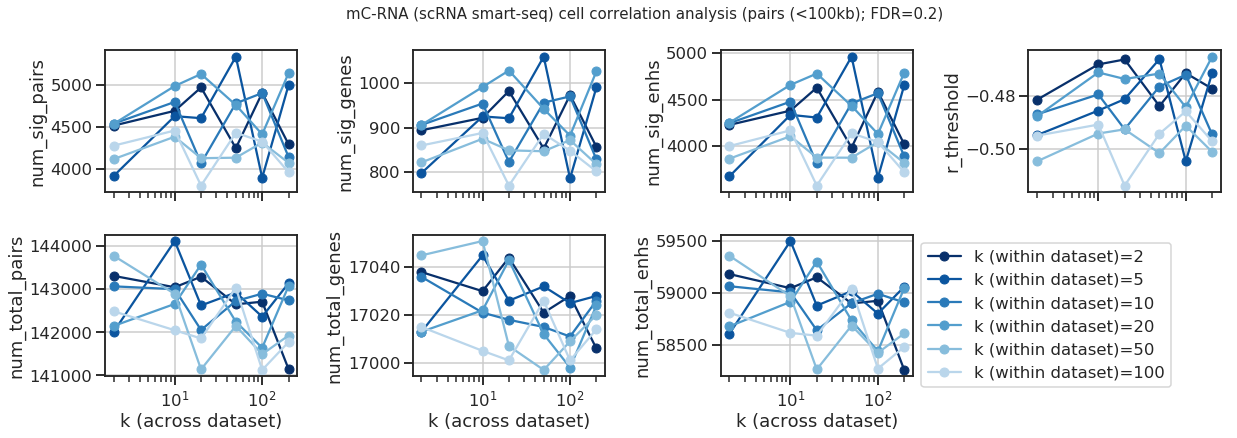

In [218]:
# plot (x - across)
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
ka_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (ka, _table) in enumerate(res.groupby('ka')):
        _table = _table.sort_values('k')
        ax.plot(_table['k'], _table[col], '-o', 
                color=ka_colors[i], 
                label='k (within dataset)={}'.format(ka))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (across dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure1)
plt.show()

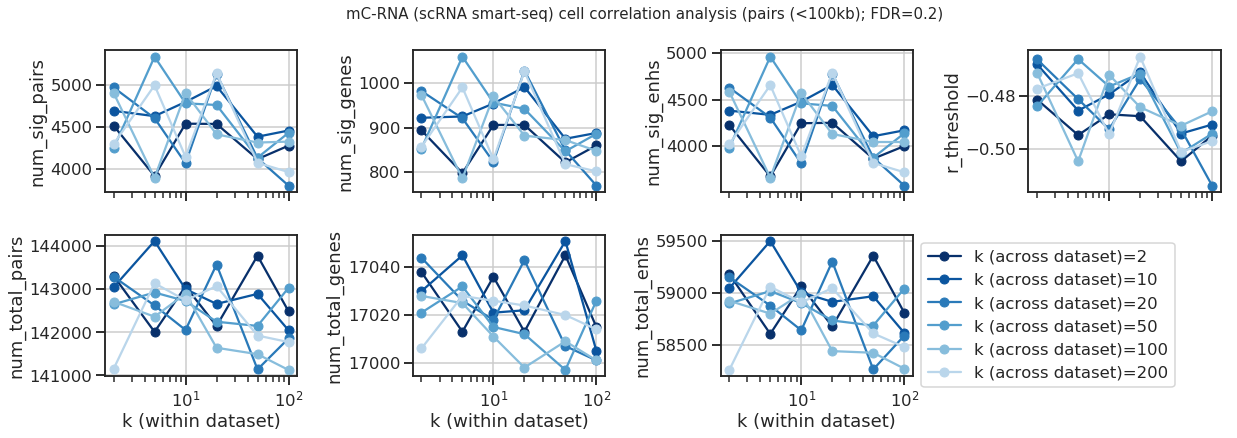

In [219]:
# plot (x - within)

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (k, _table) in enumerate(res.groupby('k')):
        _table = _table.sort_values('ka')
        ax.plot(_table['ka'], _table[col], '-o', 
                color=k_colors[i], 
                label='k (across dataset)={}'.format(k))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure2)
plt.show()

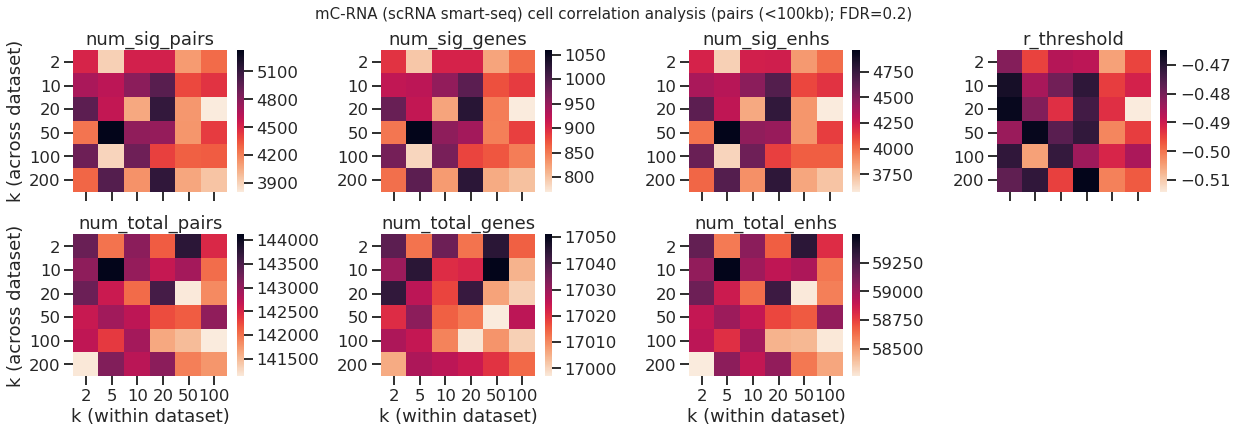

In [221]:
res_pivot = pd.pivot(res, index='k', columns='ka')

# plot same ks
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    sns.heatmap(res_pivot[col], cmap='rocket_r', ax=ax)

    ax.set_title(col)
    
    if i_ax in (0, 4):
        ax.set_ylabel('k (across dataset)')
    else:
        ax.set_ylabel('')
        
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    else:
        ax.set_xlabel('')
        
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure4)
plt.show()

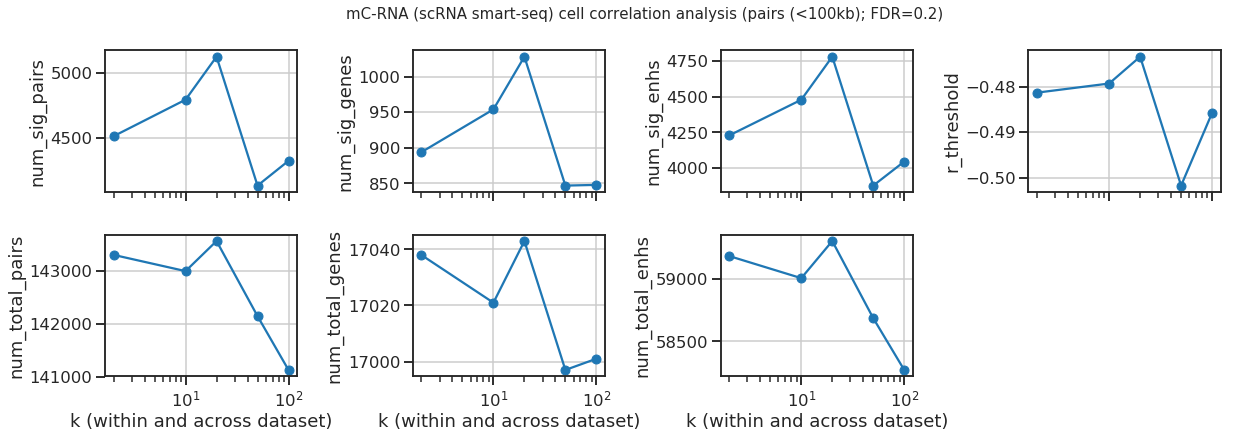

In [220]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive - shuffling cells as the null hypothesis 

In [222]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [223]:
today = datetime.date.today()
print(today)

2020-08-04


In [224]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v4.pdf'.format(today)

In [225]:
# enhancer-gene linkage
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)
enhancer_gene_to_eval.head()

(2589994, 18)


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [226]:
# 

ka_list = [2, 5, 10, 20, 50, 100, 200] 
k_list = [2, 50, 10, 20, 50, 100, 200]

num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
label = 'pairs (<100kb)'


res = []

for ka in ka_list:
    for k in k_list:
        # 
        output_corr = output_corr_format.format(ka, k)
        output_to_correlate = output_to_correlate_format.format(ka, k)
        
        # try loading the list
        try:
            with open(output_corr, 'rb') as fh:
                corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

            with open(output_to_correlate, 'rb') as fh:
                to_correlate = pickle.load(fh)
            print(to_correlate.shape)
        except:
            continue
        
        # dists 
        dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
        
#         # total numbers
#         num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
#         num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
#         num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
        
        ## sig numbers
        label_cond = dists < 1e5
        track = corrs[label_cond]
        
        ### total numbers with the condition
        num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
        num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
        num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

        hist_shuff, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
        cdf_shuff = np.cumsum(hist_shuff)
        # dist
        hist, _ = np.histogram(track, bins=bins, normed=True)
        cdf = np.cumsum(hist)
        # fdr
        fdr = cdf_shuff/cdf

        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr)
        _y = fdr[~isnan]
        _x = bins[1:][~isnan]
        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0

        sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

        # num_sig
        num_sig_pairs = len(sig_table)
        num_sig_genes = len(sig_table['gene'].unique()) 
        num_sig_enhs = len(sig_table['ens'].unique()) 

        # record
        res.append({
            'ka': ka,
            'k': k,
            'num_total_pairs': num_total_pairs,
            'num_total_genes': num_total_genes,
            'num_total_enhs': num_total_enhs,
            'num_sig_pairs': num_sig_pairs,
            'num_sig_genes': num_sig_genes,
            'num_sig_enhs': num_sig_enhs,
            'r_threshold': r_threshold,
        })
        
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

(1546436,) (1546436,) (1546436,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


(1539635,) (1539635,) (1539635,)
(2589994,)
(1543164,) (1543164,) (1543164,)
(2589994,)
(1546273,) (1546273,) (1546273,)
(2589994,)
(1539635,) (1539635,) (1539635,)
(2589994,)
(1539798,) (1539798,) (1539798,)
(2589994,)
(1522985,) (1522985,) (1522985,)
(2589994,)
(1532335,) (1532335,) (1532335,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1555150,) (1555150,) (1555150,)
(2589994,)
(1538700,) (1538700,) (1538700,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1536987,) (1536987,) (1536987,)
(2589994,)
(1543970,) (1543970,) (1543970,)
(2589994,)
(1543906,) (1543906,) (1543906,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1542335,) (1542335,) (1542335,)
(2589994,)
(1533257,) (1533257,) (1533257,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1541895,) (1541895,) (1541895,)
(2589994,)
(1539550,) (1539550,) (1539550,)
(2589994,)
(1534403,) (1534403,) (1534403,)
(2589994,)
(1535991,) (1535991,) (1535991,)
(2589994,)
(1539372,) (1539372,) (1539372,)

ka   k  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0   2   2          91178          15426         47683    -0.013453   
1   2  50          90477          15353         47442    -0.013307   
2   2  10          89396          15284         47008    -0.014860   
3   2  20          89811          15300         47271    -0.015227   
4   2  50          90477          15353         47442    -0.013307   

   num_total_pairs  num_total_genes  num_total_enhs  
0           143311            17038           59180  
1           142651            17021           58898  
2           143047            17030           59044  
3           143291            17044           59149  
4           142651            17021           58898

In [227]:
res = res.groupby(['ka', 'k']).first().reset_index()
res.shape

(36, 9)

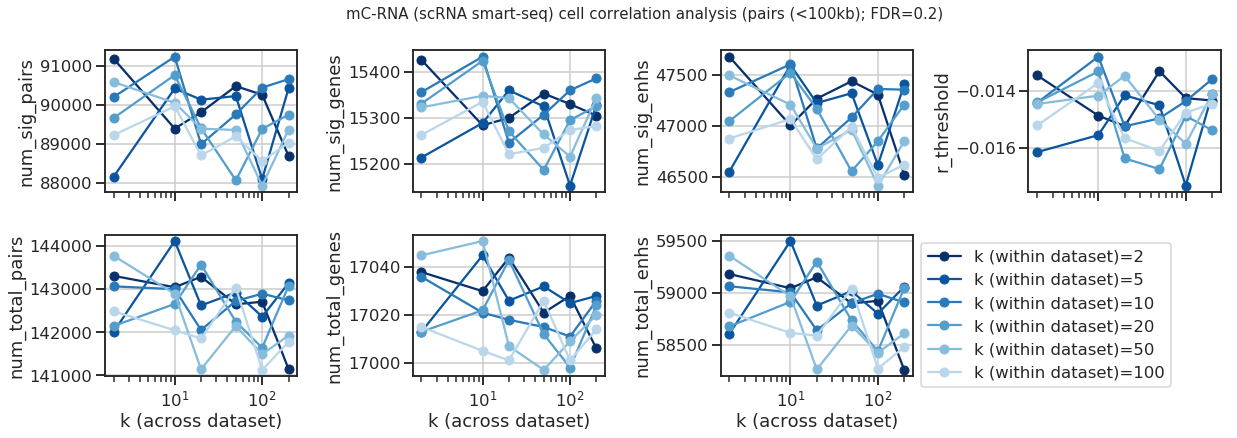

In [228]:
# plot (x - across)
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
ka_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (ka, _table) in enumerate(res.groupby('ka')):
        _table = _table.sort_values('k')
        ax.plot(_table['k'], _table[col], '-o', 
                color=ka_colors[i], 
                label='k (within dataset)={}'.format(ka))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (across dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure1)
plt.show()

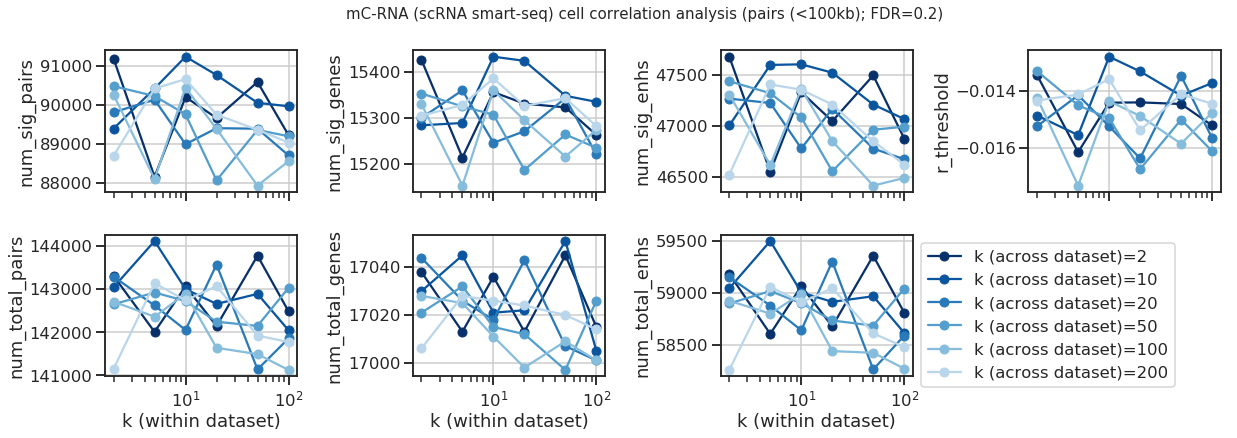

In [229]:
# plot (x - within)

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (k, _table) in enumerate(res.groupby('k')):
        _table = _table.sort_values('ka')
        ax.plot(_table['ka'], _table[col], '-o', 
                color=k_colors[i], 
                label='k (across dataset)={}'.format(k))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure2)
plt.show()

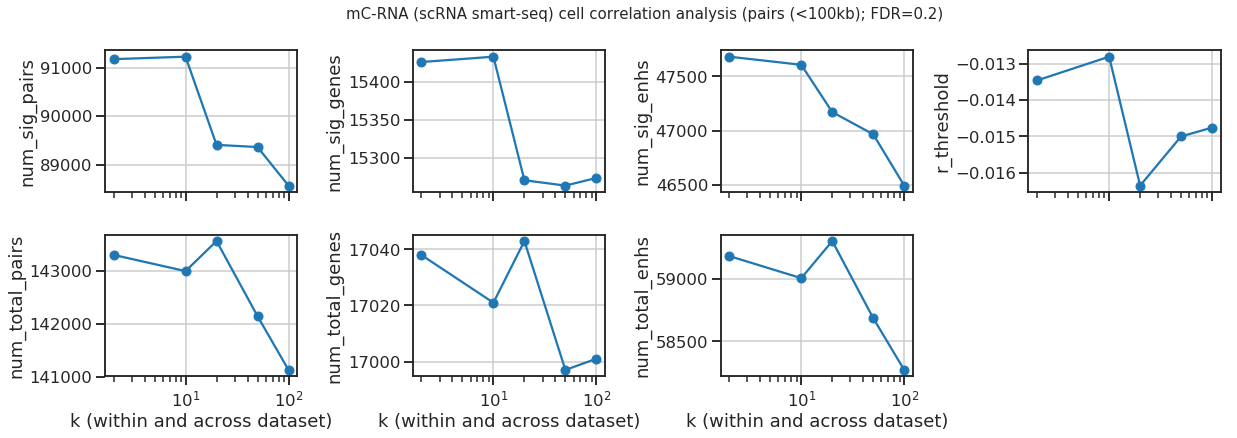

In [230]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

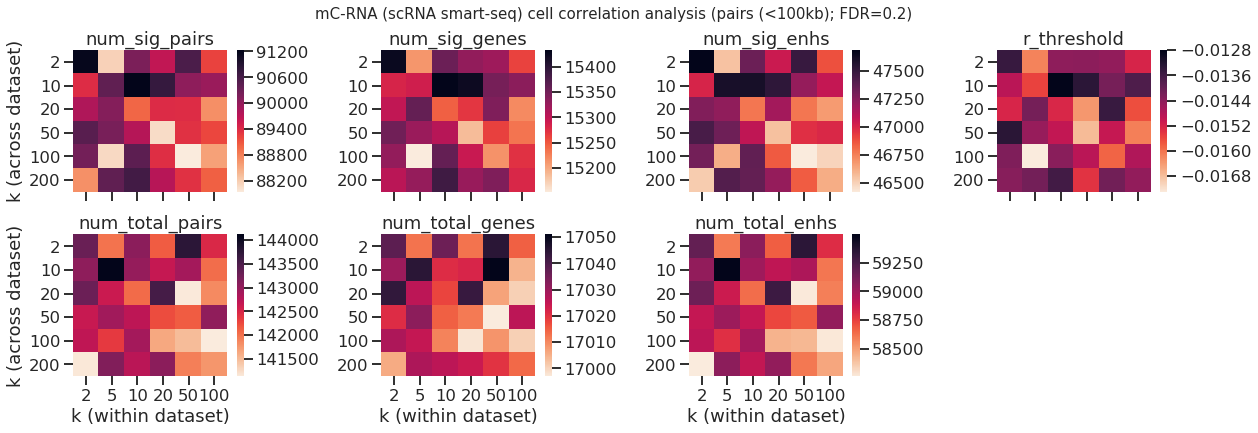

In [231]:
res_pivot = pd.pivot(res, index='k', columns='ka')

# plot same ks
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    sns.heatmap(res_pivot[col], cmap='rocket_r', ax=ax)

    ax.set_title(col)
    
    if i_ax in (0, 4):
        ax.set_ylabel('k (across dataset)')
    else:
        ax.set_ylabel('')
        
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    else:
        ax.set_xlabel('')
        
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure4)
plt.show()

# Plot massive (2nd iteration) 

In [316]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [317]:
today = datetime.date.today()
print(today)

2020-08-07


In [318]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v4.pdf'.format(today)

In [319]:
f_pattern = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_*corrs.pkl"
fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_k[0-9]+", fname)[0][len("_k"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             fname, fname.replace('corrs.pkl', 'corrs_idx.pkl'),
            ) for fname in fnames]
res = []
for k, ka, output_corr, output_to_correlate in iterator:
    print(k, ka)
        # 
#     output_corr = output_corr_format.format(ka, k)
#     output_to_correlate = output_to_correlate_format.format(ka, k)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    
    # ## total numbers
    # num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
    # num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
    # num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
    
    
    ## sig numbers
    label_cond = dists < 1e5
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    # find r threshold
    try:
        f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
        r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
    except:
        r_threshold = 0

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

5 10
(1543792,) (1543792,) (1543792,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


5 100
(1535593,) (1535593,) (1535593,)
(2589994,)
9 9
(1516127,) (1516127,) (1516127,)
(2589994,)
200 200
(1531229,) (1531229,) (1531229,)
(2589994,)
5 5
(1548445,) (1548445,) (1548445,)
(2589994,)
20 20
(1549514,) (1549514,) (1549514,)
(2589994,)
100 2
(1539798,) (1539798,) (1539798,)
(2589994,)
50 5
(1542719,) (1542719,) (1542719,)
(2589994,)
5 20
(1541216,) (1541216,) (1541216,)
(2589994,)
40 40
(1536107,) (1536107,) (1536107,)
(2589994,)
100 50
(1527455,) (1527455,) (1527455,)
(2589994,)
50 200
(1522736,) (1522736,) (1522736,)
(2589994,)
15 15
(1533125,) (1533125,) (1533125,)
(2589994,)
75 75
(1544159,) (1544159,) (1544159,)
(2589994,)
500 500
(1519964,) (1519964,) (1519964,)
(2589994,)
50 2
(1539635,) (1539635,) (1539635,)
(2589994,)
6 6
(1533823,) (1533823,) (1533823,)
(2589994,)
2 200
(1531908,) (1531908,) (1531908,)
(2589994,)
50 50
(1533816,) (1533816,) (1533816,)
(2589994,)
200 5
(1543970,) (1543970,) (1543970,)
(2589994,)
200 100
(1529874,) (1529874,) (1529874,)
(2589994,)
1

ka    k  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0   10    5           4675            931          4379    -0.484508   
1  100    5           4269            860          3998    -0.496061   
2    9    9           4747            951          4431    -0.443487   
3  200  200           3955            796          3709    -0.506771   
4    5    5           4907            984          4592    -0.478147   

   num_total_pairs  num_total_genes  num_total_enhs  
0           143012            17030           59048  
1           142296            17011           58741  
2           140444            16974           57985  
3           141820            17005           58579  
4           143484            17028           59217

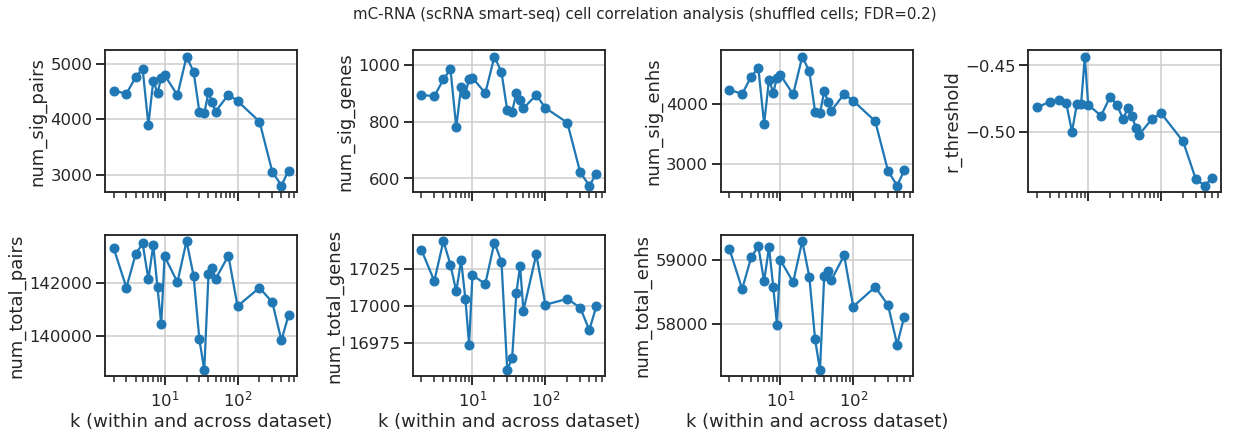

In [320]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

In [321]:
_table.sort_values('ka')

ka    k  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
22    2    2           4514            894          4229    -0.481292   
63    3    3           4455            889          4163    -0.477120   
34    4    4           4753            948          4450    -0.475476   
4     5    5           4907            984          4592    -0.478147   
16    6    6           3899            780          3665    -0.499586   
57    7    7           4693            923          4400    -0.479043   
39    8    8           4465            896          4182    -0.478928   
2     9    9           4747            951          4431    -0.443487   
56   10   10           4794            954          4478    -0.479290   
12   15   15           4431            900          4155    -0.487710   
5    20   20           5124           1028          4779    -0.473397   
33   25   25           4854            974          4535    -0.479650   
24   30   30           4130            839          3866    -0.490093   
50   35   35           4104            835          3842    -0.482128   
9    40   40           4483            901          4203    -0.487467   
30   45   45           4301            876          4035    -0.496793   
18   50   50           4135            847          3878    -0.501715   
13   75   75           4440            893          4161    -0.489964   
37  100  100           4325            848          4046    -0.485746   
3   200  200           3955            796          3709    -0.506771   
64  300  300           3050            622          2882    -0.535160   
43  400  400           2801            575          2640    -0.539803   
14  500  500           3071            616          2892    -0.533783   

    num_total_pairs  num_total_genes  num_total_enhs  
22           143311            17038           59180  
63           141824            17017           58547  
34           143071            17044           59047  
4            143484            17028           59217  
16           142140            17010           58668  
57           143416            17031           59203  
39           141833            17005           58584  
2            140444            16974           57985  
56           143003            17021           59004  
12           142024            17015           58654  
5            143574            17043           59300  
33           142265            17030           58738  
24           139877            16957           57755  
50           138730            16965           57276  
9            142317            17009           58748  
30           142553            17027           58832  
18           142149            16997           58685  
13           143022            17035           59075  
37           141127            17001           58272  
3            141820            17005           58579  
64           141271            16999           58293  
43           139842            16984           57675  
14           140786            17000           58115

# Plot massive (3nd iteration - subsampling) 

In [57]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

In [58]:
today = datetime.date.today()
print(today)

2020-08-17


In [59]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v4.pdf'.format(today)

In [60]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
8.127815008163452


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [61]:
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
distance_threshold = 1e5

label = 'pairs (<100kb)'

In [62]:
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "corr_analysis_smarter_cells_snmcseq_gene_ka[0-9]*_knn[0-9]*_*_[0-9]_corrs.pkl"
            )

fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_knn[0-9]+", fname)[0][len("_knn"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
fnames[:5]

['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka50_knn50_200807_2020-08-13_5_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka25_knn25_200807_2020-08-14_8_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka40_knn40_200807_2020-08-15_3_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka4_knn4_200807_2020-08-17_9_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka5_knn5_200807_2020-08-12_6_corrs.pkl']

In [63]:
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
#     print(dists.shape, corrs.shape, corrs[:5])
    
    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            r_threshold = sol.root
        else:
            print("failed to detect r_threshold:", k, ka, i_sub)
            continue # failed
    else:
        print("failed to detect r_threshold:", k, ka, i_sub)
        # r_threshold = 0
        continue # failed

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

50 50
(2586169,) (2586169,) (2586169,)
(2589994,)
25 25
(1914193,) (1914193,) (1914193,)
(2589994,)
40 40
(2507098,) (2507098,) (2507098,)
(2589994,)
4 4
(10987,) (10987,) (10987,)
(2589994,)
5 5
(42832,) (42832,) (42832,)
(2589994,)
6 6
(80190,) (80190,) (80190,)
(2589994,)
3 3
(2091,) (2091,) (2091,)
(2589994,)
500 500
(2589994,) (2589994,) (2589994,)
(2589994,)
9 9
(370701,) (370701,) (370701,)
(2589994,)
50 50
(2585823,) (2585823,) (2585823,)
(2589994,)
5 5
(41086,) (41086,) (41086,)
(2589994,)
4 4
(11500,) (11500,) (11500,)
(2589994,)
40 40
(2518368,) (2518368,) (2518368,)
(2589994,)
25 25
(1886237,) (1886237,) (1886237,)
(2589994,)
3 3
(2296,) (2296,) (2296,)
(2589994,)
6 6
(83706,) (83706,) (83706,)
(2589994,)
9 9
(364356,) (364356,) (364356,)
(2589994,)
500 500
(2589994,) (2589994,) (2589994,)
(2589994,)
5 5
(39809,) (39809,) (39809,)
(2589994,)
40 40
(2514658,) (2514658,) (2514658,)
(2589994,)
50 50
(2585800,) (2585800,) (2585800,)
(2589994,)
500 500
(2589994,) (2589994,) (258

ka   k  i_sub  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0  50  50      5           5844            825          5540    -0.573029   
1  25  25      8           4650            833          4376    -0.523220   
2  40  40      3           5944            859          5627    -0.546061   
3   4   4      9            176            135           155    -0.253331   
4   5   5      6            444            315           401    -0.301270   

   num_total_pairs  num_total_genes  num_total_enhs  
0           242063            18051          100710  
1           177904            17494           73719  
2           234557            17990           97514  
3             1028              871             402  
4             3954             2989            1558

In [64]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# res_mean
_table_std.head()


# record
table_res_knn = _table
table_std_res_knn = _table_std

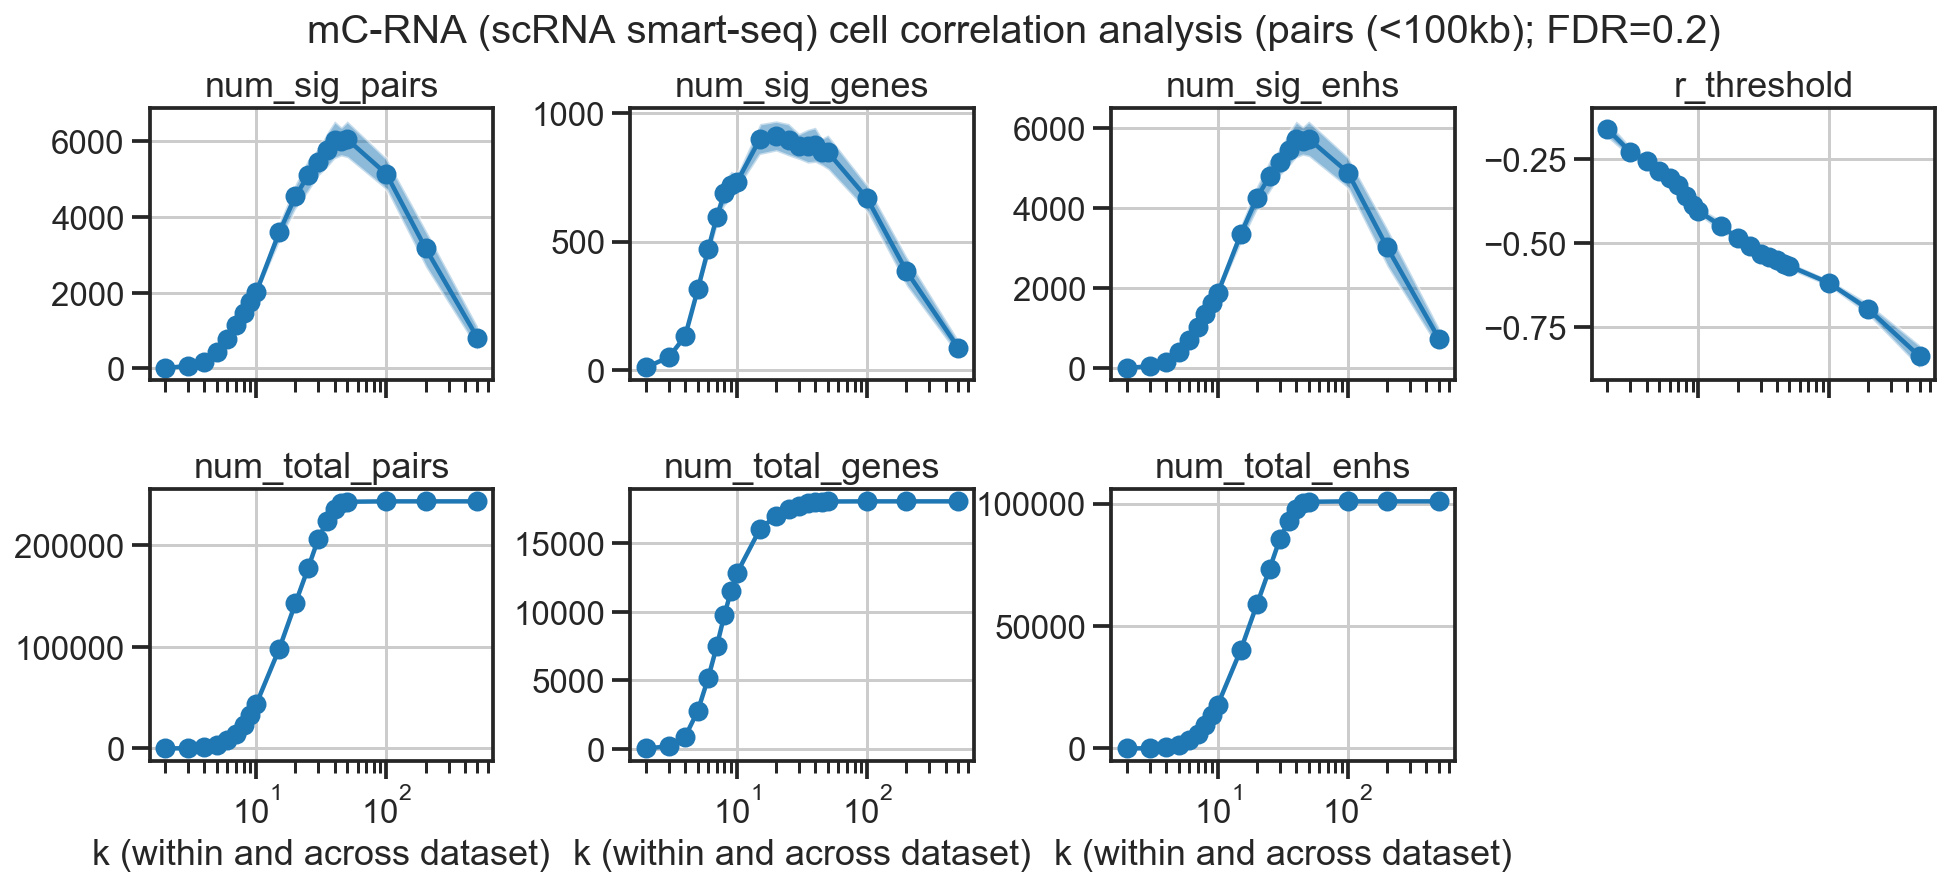

In [65]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive (3nd iteration - within mC) 

In [66]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

In [67]:
today = datetime.date.today()
print(today)

2020-08-17


In [68]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_within_mc_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_within_mc_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_within_mc_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_within_mc_num_sig_dependency_k_only_v4.pdf'.format(today)

In [69]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
6.589632749557495


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [70]:
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
distance_threshold = 1e5
CORR_SIGN = -1

label = 'pairs (<100kb)'

In [71]:
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "corr_analysis_withinmc_ka[0-9]*_knn[0-9]*_*_[0-9]_corrs.pkl"
            )

fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_knn[0-9]+", fname)[0][len("_knn"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
fnames[:5]

['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka7_knn7_200807_2020-08-17_9_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka25_knn25_200807_2020-08-14_4_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka8_knn8_200807_2020-08-17_5_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka50_knn50_200807_2020-08-13_9_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka45_knn45_200807_2020-08-16_6_corrs.pkl']

In [72]:
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            corrs *= CORR_SIGN 
            corrs_shuffled *= CORR_SIGN 
            corrs_shuffled_cells *= CORR_SIGN 
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    print(dists.shape, corrs.shape, corrs[:5])
    
    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            r_threshold = sol.root
        else:
            print("failed to detect r_threshold:", k, ka, i_sub)
            continue # failed
    else:
        print("failed to detect r_threshold:", k, ka, i_sub)
        # r_threshold = 0
        continue # failed

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

7 7
(2015805,) (2015805,) (2015805,)
(2589994,)
(2015805,) (2015805,) [-0.22735578 -0.12252812 -0.21404088  0.10174853 -0.35694113]
25 25
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [-0.2847374  -0.19411667 -0.17417318  0.01095331 -0.26214927]
8 8
(2233029,) (2233029,) (2233029,)
(2589994,)
(2233029,) (2233029,) [-0.22068466 -0.12422676 -0.13841131  0.04621227 -0.18324257]
50 50
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [-0.27607048 -0.28919727 -0.20544915 -0.09345993 -0.2890987 ]
45 45
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [-0.32911575 -0.25755355 -0.19645834 -0.0203913  -0.2751933 ]
200 200
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [-0.41042206 -0.5413588  -0.28888297 -0.10748861 -0.18443629]
100 100
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [-0.30315676 -0.34079146 -0.245102   -0.12561081 -0.31977877]
30 30
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (

ka   k  i_sub  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0   7   7      9          12184           3130         10388    -0.580092   
1  25  25      4          12717           3150         10935    -0.685465   
2   8   8      5          13617           3333         11588    -0.586198   
3  50  50      9          10770           2878          9302    -0.742832   
4  45  45      6          11792           3081         10109    -0.726260   

   num_total_pairs  num_total_genes  num_total_enhs  
0           187581            17584           77800  
1           242446            18062          100876  
2           208079            17786           86503  
3           242446            18062          100876  
4           242446            18062          100876

In [73]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# res_mean
_table_std.head()

# record
table_res_knn_mconly = _table
table_std_res_knn_mconly = _table_std

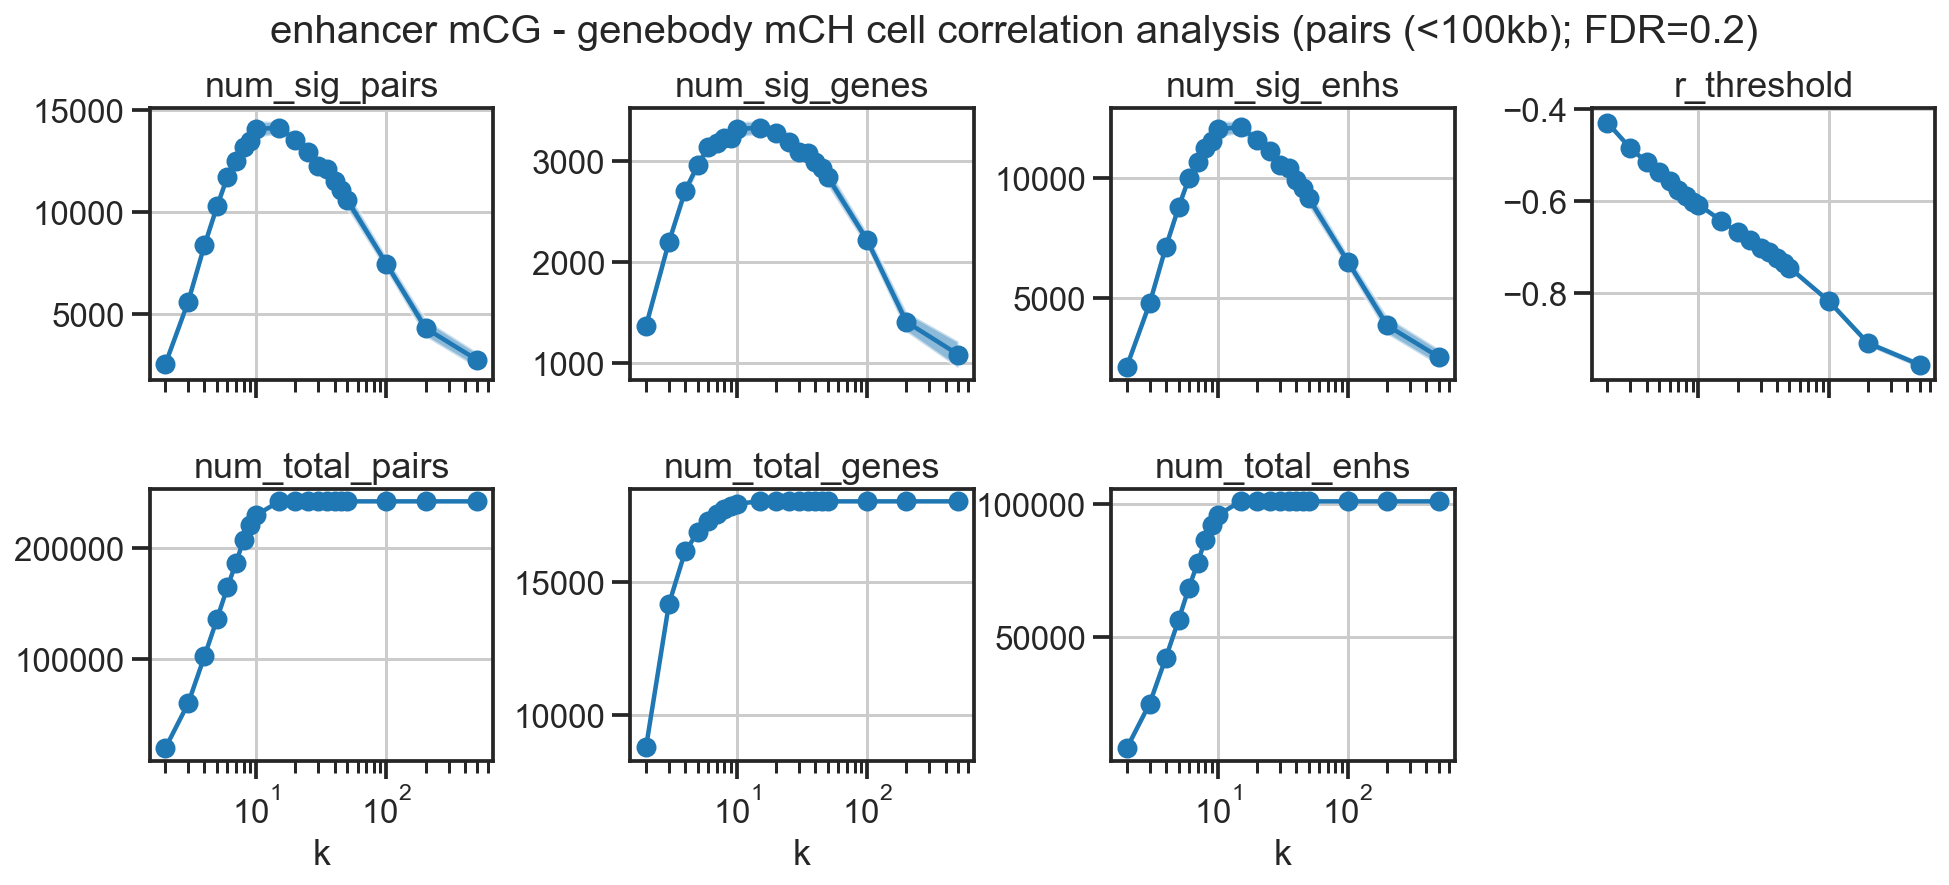

In [74]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('enhancer mCG - genebody mCH cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99,
            )

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive (3nd iteration - restrict kNN within clusters) 

In [75]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

In [76]:
today = datetime.date.today()
print(today)

2020-08-17


In [77]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_restricted_knn_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_restricted_knn_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_restricted_knn_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_restricted_knn_num_sig_dependency_k_only_v4.pdf'.format(today)

In [78]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
5.617230653762817


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [79]:
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
distance_threshold = 1e5

label = 'pairs (<100kb)'

In [80]:
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka[0-9]*_knn[0-9]*_*_[0-9]_corrs.pkl"
            )

fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_knn[0-9]+", fname)[0][len("_knn"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
fnames[:5]

['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka30_knn30_200811_2020-08-13_9_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka10_knn10_200811_2020-08-12_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka100_knn100_200811_2020-08-12_8_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka6_knn6_200811_2020-08-13_7_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_within_cluster_knn_ka3_knn3_200811_2020-08-13_3_corrs.pkl']

In [81]:
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    print(dists.shape, corrs.shape, corrs[:5])
    
    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            r_threshold = sol.root
        else:
            print("failed to detect r_threshold:", k, ka, i_sub)
            continue # failed
    else:
        print("failed to detect r_threshold:", k, ka, i_sub)
        # r_threshold = 0
        continue # failed

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
colunms = [
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]
res = pd.DataFrame(res)[columns] 
print(res.shape)
res.head()

30 30
(2246521,) (2246521,) (2246521,)
(2589994,)
(2246521,) (2246521,) [ 0.04295645 -0.03655556 -0.05668289  0.08910514  0.0837806 ]
10 10
(554337,) (554337,) (554337,)
(2589994,)
(554337,) (554337,) [-0.03311075 -0.01917816 -0.16979253 -0.06463467 -0.11638808]
100 100
(2589994,) (2589994,) (2589994,)
(2589994,)
(2589994,) (2589994,) [ 0.05076176 -0.15022418 -0.09360985  0.08591574  0.08211121]
6 6
(121130,) (121130,) (121130,)
(2589994,)
(121130,) (121130,) [-0.06161654 -0.18378072  0.16111354 -0.04173592 -0.13834529]
3 3
(3426,) (3426,) (3426,)
(2589994,)
(3426,) (3426,) [-0.07839597  0.019407   -0.31887967 -0.04074277 -0.02380167]
40 40
(2518105,) (2518105,) (2518105,)
(2589994,)
(2518105,) (2518105,) [ 0.03582921 -0.08618446 -0.09065647  0.08685193  0.08983117]
2 2
(360,) (360,) (360,)
(2589994,)
(360,) (360,) [-0.0748712   0.03731136 -0.0068203  -0.12290687 -0.06670626]
10 10
(563341,) (563341,) (563341,)
(2589994,)
(563341,) (563341,) [-0.04440811  0.06502487 -0.00559765 -0.1564

ka    k  i_sub  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0   30   30      9           9403           1475          8776    -0.488566   
1   10   10      0           3437           1182          3168    -0.394515   
2  100  100      8          11003           1510         10282    -0.521165   
3    6    6      7           1215            695          1092    -0.330733   
4    3    3      3             89             77            72    -0.229126   

   num_total_pairs  num_total_genes  num_total_enhs  
0           209496            17799           86938  
1            50696            13605           20769  
2           242446            18062          100876  
3            11209             6357            4491  
4              340              284             128

In [82]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# res_mean
_table_std.head()

# record
table_res_knn_inclst = _table
table_std_res_knn_inclst = _table_std

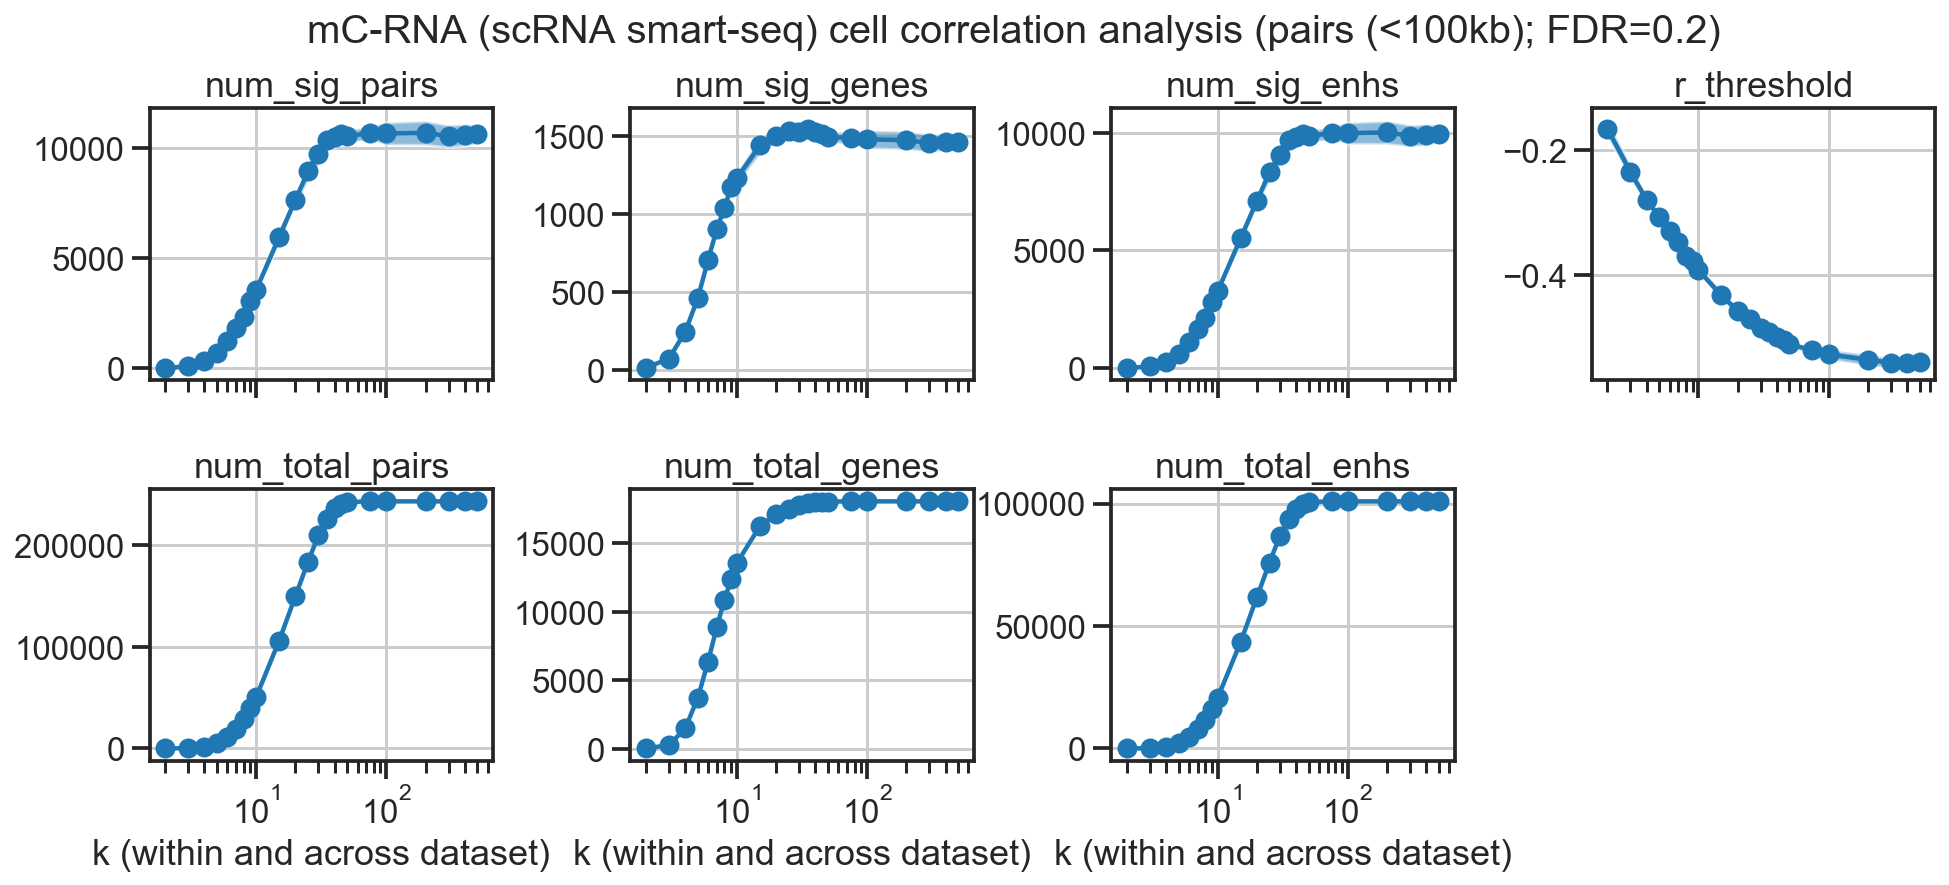

In [83]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()
for i_ax, (ax, col) in enumerate(zip(axs, columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot combined  
  

In [98]:
columns = [
    'ka',
    'k',
    'i_sub',
    'num_sig_pairs',
    'num_sig_genes',
    'num_sig_enhs',
    'r_threshold',
    'num_total_pairs',
    'num_total_genes',
    'num_total_enhs',
]


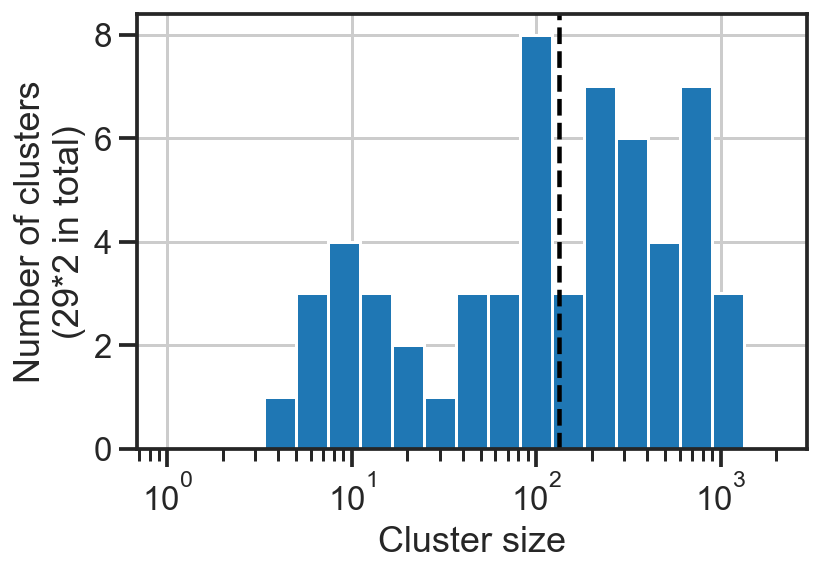

In [135]:

x = df_clst.groupby(['modality', 'joint_cluster_round2']).size()
clst_med = x.median()

fig, ax = plt.subplots()
bins = np.power(10, np.linspace(0, 3.3, 20))
ax.hist(x.values, bins=bins)
ax.axvline(clst_med, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('Cluster size')
ax.set_ylabel('Number of clusters\n(29*2 in total)')

output_figure = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cluster_histogram.pdf'.format(today)
snmcseq_utils.savefig(fig, output_figure)
plt.show()

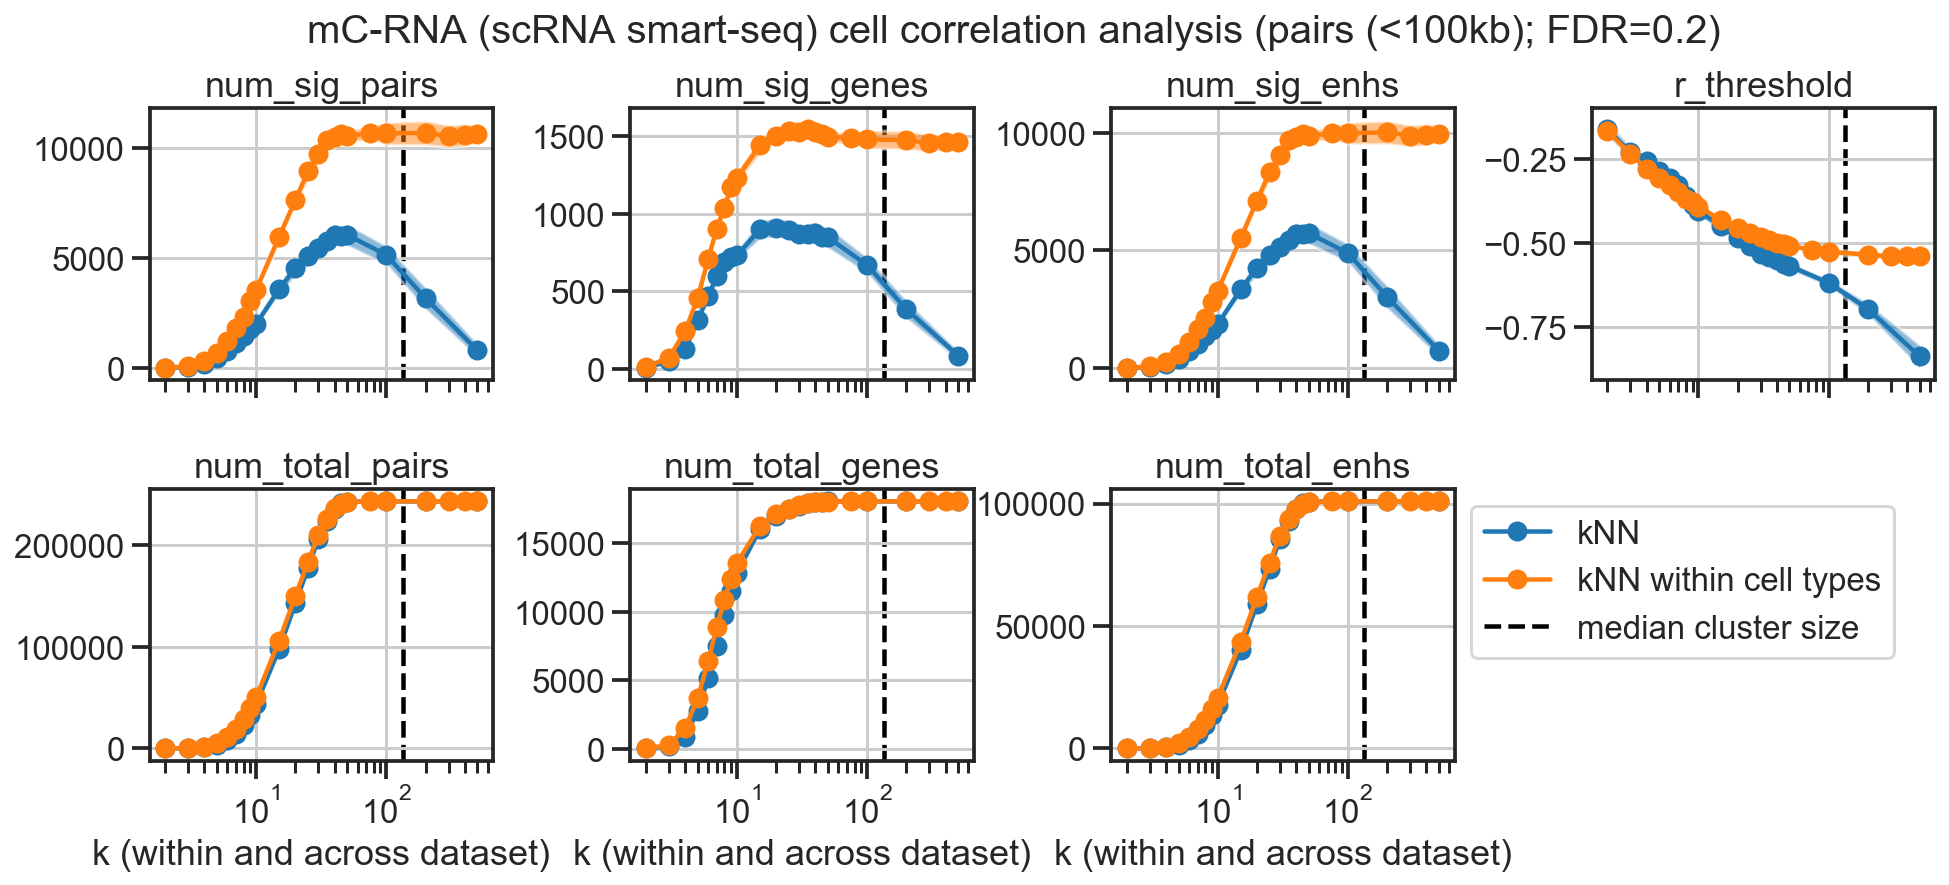

In [139]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()

_tables = [
    table_res_knn,
    table_res_knn_inclst,
]

_table_stds = [
    table_std_res_knn,
    table_std_res_knn_inclst,
]

_labels = [
    'kNN',
    'kNN within cell types', 
]

for i_ax, (ax, col) in enumerate(zip(axs, columns[3:])):
    for _table, _table_std, _label in zip(_tables, _table_stds, _labels):
        _x = _table['ka']
        _y = _table[col]
        _y_std = _table_std[col] 
        ax.plot(_x, _y, '-o', label=_label)
        ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)
        
    
    ax.axvline(clst_med, color='k', linestyle='--', zorder=0, label='median cluster size')
    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
ax.legend(bbox_to_anchor=(1,1))

axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
output_figure = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_vs_k_combined.pdf'.format(today)
snmcseq_utils.savefig(fig, output_figure)
plt.show()

# Plot massive (3nd iteration - ATAC seq) 

In [130]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

In [131]:
today = datetime.date.today()
print(today)

2020-09-02


In [132]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_v4.pdf'.format(today)

In [133]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
10.001389503479004


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [134]:
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
distance_threshold = 1e5

label = 'pairs (<100kb)'
CORR_SIGN = -1

In [135]:
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka[0-9]*_knn[0-9]*_*_corrs.pkl"
            )

fnames = np.sort(glob.glob(f_pattern))
iterator = [(int(re.findall("_knn[0-9]+", fname)[0][len("_knn"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
print(len(fnames))
fnames[:5]

49


array(['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_0_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_1_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_2_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka100_knn100_0_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka100_knn100_1_corrs.pkl'],
      dtype='<U138')

In [136]:
fnames

array(['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_0_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_1_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka1000_knn1000_2_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka100_knn100_0_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka100_knn100_1_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_200826_ka100_knn100_2_corrs.pkl',
       '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna

In [137]:
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
    
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            corrs *= CORR_SIGN 
            corrs_shuffled *= CORR_SIGN 
            corrs_shuffled_cells *= CORR_SIGN 

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
#     print(dists.shape, corrs.shape, corrs[:5])
    
    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            r_threshold = sol.root
        else:
            print("failed to detect r_threshold:", k, ka, i_sub)
            continue # failed
    else:
        print("failed to detect r_threshold:", k, ka, i_sub)
        # r_threshold = 0
        continue # failed

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

1000 1000
1000 1000
1000 1000
100 100
100 100
100 100
10 10
10 10
10 10
15 15
15 15
15 15
2000 2000
2000 2000
2000 2000
200 200
200 200
200 200
20 20
20 20
20 20
25 25
25 25
25 25
2 2
2 2
2 2
30 30
30 30
30 30
35 35
35 35
35 35
40 40
40 40
40 40
45 45
45 45
45 45
5000 5000
5000 5000
5000 5000
500 500
50 50
50 50
50 50
5 5
5 5
5 5
(49, 10)


ka     k  i_sub  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0  1000  1000      0           1394            244          1306    -0.618724   
1  1000  1000      1            574            122           539    -0.675285   
2  1000  1000      2            981            193           912    -0.637396   
3   100   100      0           4544           1091          4257    -0.391955   
4   100   100      1           4599           1086          4313    -0.392292   

   num_total_pairs  num_total_genes  num_total_enhs  
0           242446            18062          100876  
1           242446            18062          100876  
2           242446            18062          100876  
3           242446            18062          100876  
4           242446            18062          100876

In [138]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# res_mean
_table_std.head()


# record
table_res_knn = _table
table_std_res_knn = _table_std

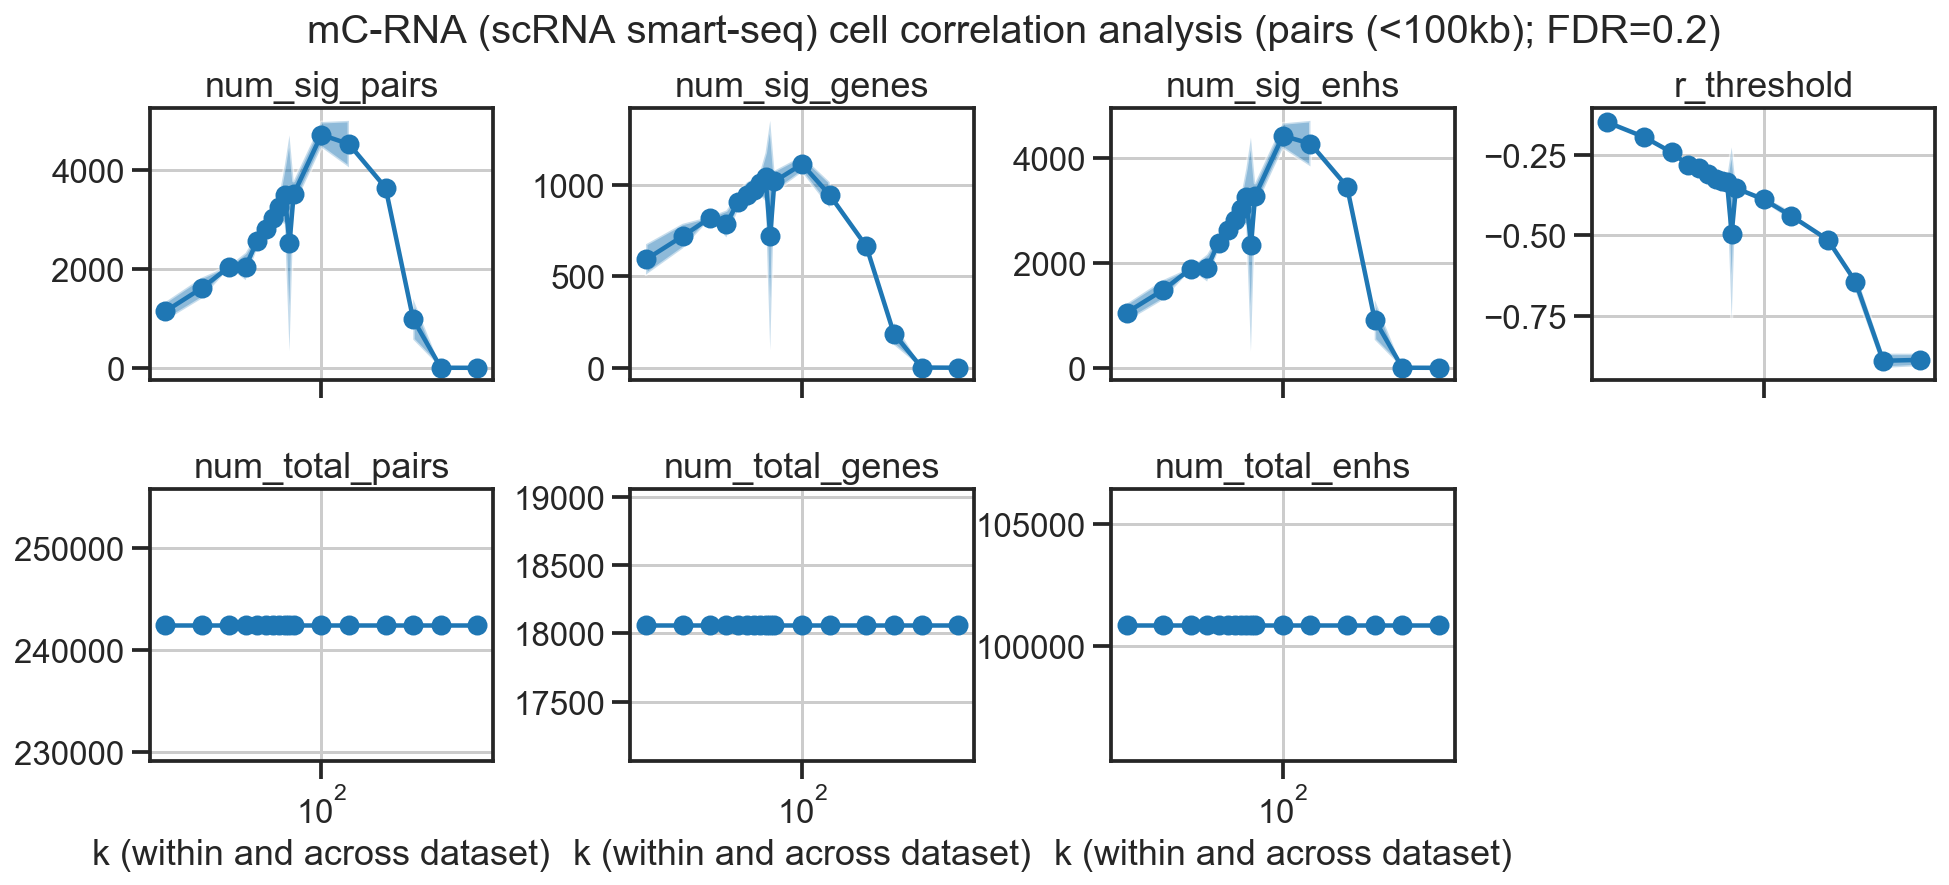

In [139]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive (3nd iteration - ATAC seq; within kNN) 

In [140]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

In [141]:
today = datetime.date.today()
print(today)

2020-09-02


In [142]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_within_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_within_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_within_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_atac_within_v4.pdf'.format(today)

In [143]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
6.846143007278442


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
0    0.872822                             1.955898 -0.285808  
1    0.987476                             0.959470  0.334610  
2    0.922832                             1.273339 -0.051866  
3    0.880982                             1.812516 -0.182514  
4    0.862033                             2.191506 -0.138090

In [144]:
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
distance_threshold = 1e5

label = 'pairs (<100kb)'
CORR_SIGN = -1

In [145]:
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka[0-9]*_knn[0-9]*_*_corrs.pkl"
            )

fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_knn[0-9]+", fname)[0][len("_knn"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
print(len(fnames))
fnames[:5]

74


['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka75_knn75_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka75_knn75_1_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka75_knn75_2_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka2000_knn2000_2_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snatac_gene_mop_2mods_atacrna_within_cluster_knn_200826_ka50_knn50_2_corrs.pkl']

In [146]:
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            corrs *= CORR_SIGN 
            corrs_shuffled *= CORR_SIGN 
            corrs_shuffled_cells *= CORR_SIGN 
#         print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
#         print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
#     print(dists.shape, corrs.shape, corrs[:5])
    
    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            r_threshold = sol.root
        else:
            print("failed to detect r_threshold:", k, ka, i_sub)
            continue # failed
    else:
        print("failed to detect r_threshold:", k, ka, i_sub)
        # r_threshold = 0
        continue # failed

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

75 75
75 75
75 75
2000 2000
50 50
50 50
2000 2000
50 50
2000 2000
20 20
25 25
3 3
5 5
300 300
7 7
9 9
400 400
300 300
3 3
25 25
400 400
9 9
7 7
5 5
9 9
400 400
3 3
25 25
7 7
300 300
5 5
8 8
5000 5000
10 10
2 2
4 4
6 6
5000 5000
8 8
2 2
6 6
4 4
2 2
8 8
6 6
5000 5000
4 4
100 100
35 35
45 45
100 100
45 45
35 35
100 100
45 45
35 35
30 30
1000 1000
1000 1000
40 40
30 30
40 40
1000 1000
30 30
40 40
200 200
15 15
500 500
500 500
15 15
200 200
500 500
200 200
15 15
(74, 10)


ka     k  i_sub  num_sig_pairs  num_sig_genes  num_sig_enhs  r_threshold  \
0    75    75      0           6499           1536          6072    -0.335630   
1    75    75      1           7504           1707          6980    -0.319283   
2    75    75      2           6923           1617          6434    -0.326756   
3  2000  2000      2           5136            758          4910    -0.566511   
4    50    50      2           6418           1606          5962    -0.306665   

   num_total_pairs  num_total_genes  num_total_enhs  
0           242446            18062          100876  
1           242446            18062          100876  
2           242446            18062          100876  
3           242446            18062          100876  
4           242446            18062          100876

In [147]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# res_mean
_table_std.head()


# record
table_res_knn_inclst = _table
table_std_res_knn_inclst = _table_std

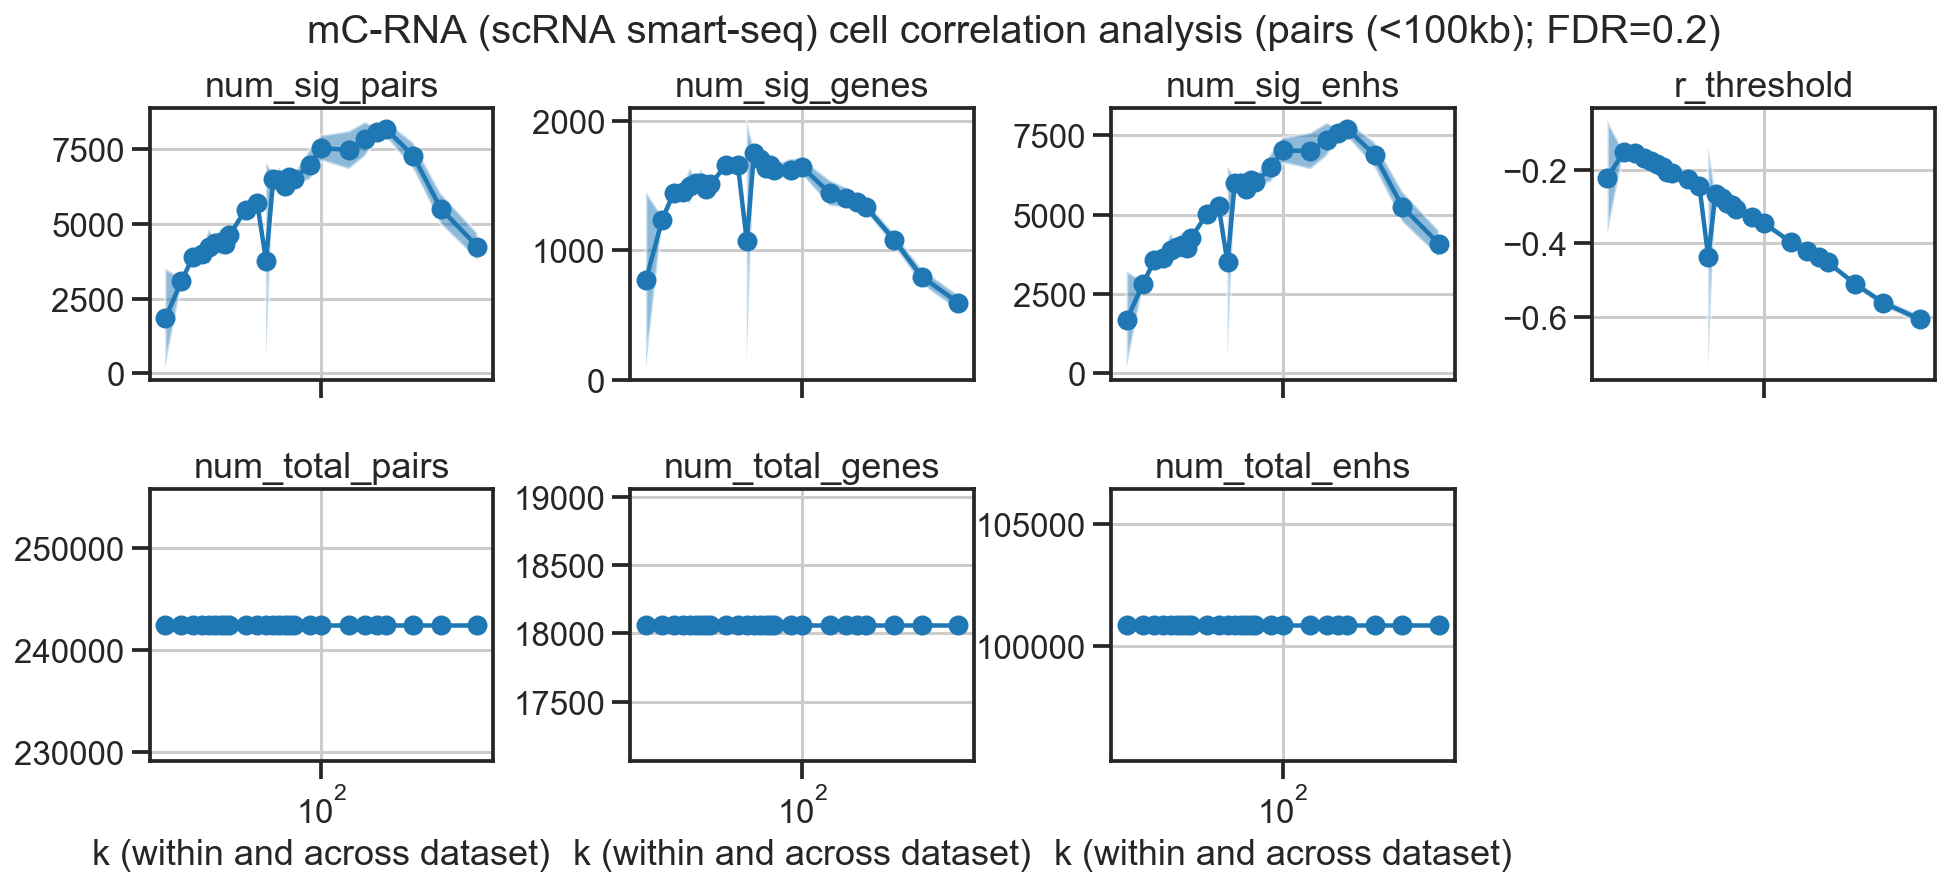

In [148]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(4*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot combined  
  

In [149]:
columns = [
    'ka',
    'k',
    'i_sub',
    'num_sig_pairs',
    'num_sig_genes',
    'num_sig_enhs',
    'r_threshold',
    'num_total_pairs',
    'num_total_genes',
    'num_total_enhs',
]


In [160]:
mods_selected = [
    'smarter_cells',
    'snatac_gene',
]

f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
df_info = pd.read_csv(f, sep='\t')
print(df_info.shape)
df_info.head()

(408885, 11)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


sample  joint_embedding_x  joint_embedding_y      modality  \
0     snmcseq_gene_2C_M_0           0.471629          -3.134735  snmcseq_gene   
1     snmcseq_gene_2C_M_1          -2.414973         -12.098081  snmcseq_gene   
2   snmcseq_gene_2C_M_100          -1.446751         -12.051894  snmcseq_gene   
3  snmcseq_gene_2C_M_1000          -1.901734         -13.660591  snmcseq_gene   
4  snmcseq_gene_2C_M_1001          -0.981086         -11.936621  snmcseq_gene   

     modality_name single_modality_cluster  single_modality_annot  \
0  DNA methylation   L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2   
1  DNA methylation             L23-IT-Cux2            L23-IT-Cux2   
2  DNA methylation             L23-IT-Cux2            L23-IT-Cux2   
3  DNA methylation             L23-IT-Cux2            L23-IT-Cux2   
4  DNA methylation             L23-IT-Cux2            L23-IT-Cux2   

   joint_cluster_round1 joint_cluster_round2 joint_cluster_round3  \
0                     1                  1-1                1-1-1   
1                     4                  4-2                4-2-1   
2                     4                  4-1                4-1-1   
3                     4                  4-2                4-2-1   
4                     4                  4-1                4-1-1   

  joint_cluster_round4  
0              1-1-1-1  
1              4-2-1-1  
2              4-1-1-1  
3              4-2-1-1  
4              4-1-1-1

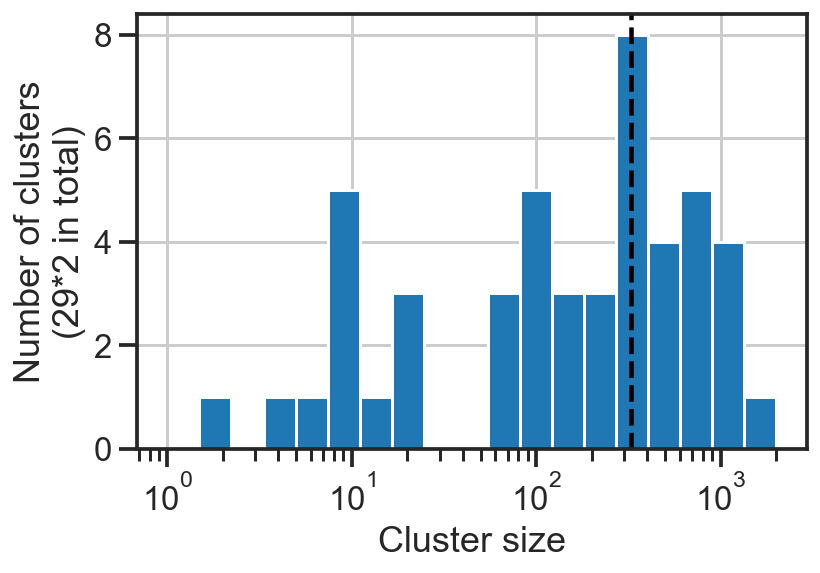

In [161]:
df_clst = df_info[df_info['modality'].isin(mods_selected)]

x = df_clst.groupby(['modality', 'joint_cluster_round2']).size()
clst_med = x.median()

fig, ax = plt.subplots()
bins = np.power(10, np.linspace(0, 3.3, 20))
ax.hist(x.values, bins=bins)
ax.axvline(clst_med, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('Cluster size')
ax.set_ylabel('Number of clusters\n(29*2 in total)')

output_figure = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cluster_histogram.pdf'.format(today)
# snmcseq_utils.savefig(fig, output_figure)
plt.show()

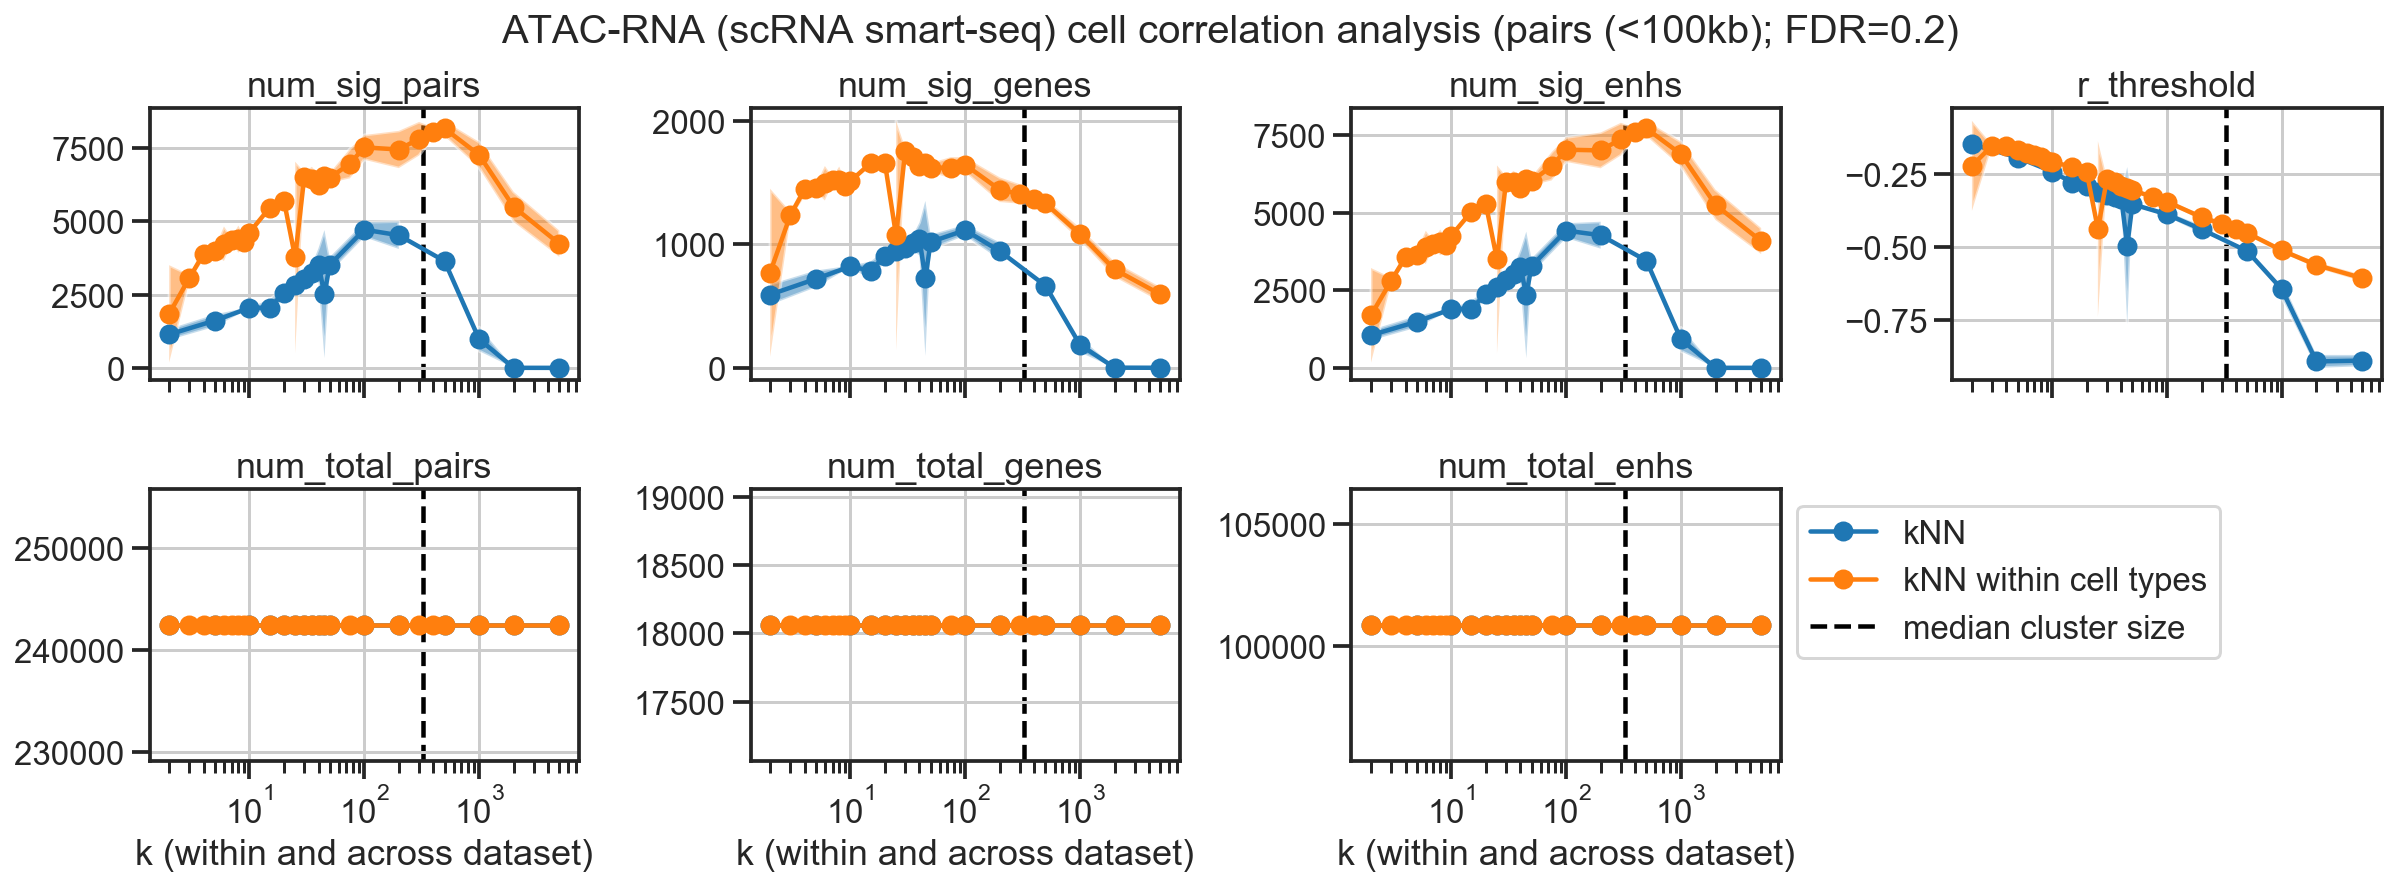

In [163]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('ATAC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=20, y=0.99)

axs = axs.flatten()

_tables = [
    table_res_knn,
    table_res_knn_inclst,
]

_table_stds = [
    table_std_res_knn,
    table_std_res_knn_inclst,
]

_labels = [
    'kNN',
    'kNN within cell types', 
]

for i_ax, (ax, col) in enumerate(zip(axs, columns[3:])):
    for _table, _table_std, _label in zip(_tables, _table_stds, _labels):
        _x = _table['ka']
        _y = _table[col]
        _y_std = _table_std[col] 
        ax.plot(_x, _y, '-o', label=_label)
        ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)
        
    ax.axvline(clst_med, color='k', linestyle='--', zorder=0, label='median cluster size')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xscale('log')
    ax.set_title(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.4, hspace=0.4)
output_figure = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_vs_k_atac_combined.pdf'.format(today)
snmcseq_utils.savefig(fig, output_figure)
plt.show()